In [1]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import pymc3 as pm
import matplotlib.pyplot as plt

In [2]:
import theano
tmp = theano.config.blas.ldflags
theano.config.blas.ldflags = '-L/Users/bara947/.local/intelpython3/envs/u18fest_env/lib -lmkl_rt -lpthread -lm -lm -Wl'

In [3]:
npr.seed(0)

In [4]:
x1 = np.array([1300, 1300, 1300, 1300, 1300, 1300, 1200, 1200, 1200, 1200, 1200, 1200, 1100, 1100, 1100, 1100])
x2 = np.array([7.5, 9.0, 11.0, 13.5, 17.0, 23.0, 5.3, 7.5, 11.0, 13.5, 17.0, 23.0, 5.3, 7.5, 11.0, 17.0])
x3 = np.array([0.0120, 0.0120, 0.0115, 0.0130, 0.0135, 0.0120, 0.0400, 0.0380, 0.0320, 0.0260, 0.0340, 0.0410, 0.0840, 0.0980, 0.0920, 0.0860])
yobs = np.array([49.0, 50.2, 50.5, 48.5, 47.5, 44.5, 28.0, 31.5, 34.5, 35.0, 38.0, 38.5, 15.0, 17.0, 20.5, 19.5])

In [5]:
normalize = lambda x : (x - np.mean(x)) / np.std(x)

x1n = normalize(x1)
x2n = normalize(x2)
x3n = normalize(x3)

In [6]:
X = np.vstack([x1, x2, x3, x1*x2, x1*x3, x2*x3, x1**2, x2**2, x3**2])

In [7]:
# Xn = np.vstack([x1n, x2n, x3n, x1n*x2n, x1n*x3n, x2n*x3n, x1n**2, x2n**2, x3n**2])
Xn = np.vstack([x1n, x2n, x3n, x1n*x2n, x2n*x3n])

In [8]:
model = pm.Model()
with model:
    alpha = pm.Flat('alpha')
    # alpha = pm.Normal('alpha', mu=0, sd=10)
    
    # tau = pm.HalfNormal('tau', sd=1)
    tau = pm.HalfStudentT('tau', nu=4, sd=1)
    
    # xi  = pm.Bernoulli('xi', 0.5, shape=Xn.shape[0])
    
    # beta  = pm.Flat('beta', shape=Xn.shape[0])
    # beta  = pm.Normal('beta', mu=0, sd=1, shape=Xn.shape[0])
    beta  = pm.Normal('beta', mu=0, sd=tau, shape=Xn.shape[0])
    # beta  = pm.StudentT('beta', nu=4, mu=0, sd=1, shape=Xn.shape[0])
    
    # bb = pm.Deterministic('bb', xi * beta)
    
    # sigma = pm.HalfNormal('sigma', sd=1)
    sigma = pm.HalfCauchy('sigma', beta=1)
    # sigma = pm.HalfFlat('sigma')
    
    mu    = alpha + pm.math.dot(beta, Xn)
    # mu    = alpha + pm.math.dot(bb, Xn)
    
    y     = pm.Normal('y', mu=mu, sd=sigma, observed=yobs)
    # y     = pm.Normal('y', mu=mu, sd=1, observed=yobs)

In [9]:
with model:
    map_estimate = pm.find_MAP()

/Users/bara947/.local/intelpython3/envs/u18fest_env/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 1.3681, ||grad|| = 4.6889e+08: 100%|██████████| 120/120 [00:00<00:00, 2929.12it/s]  


In [10]:
print(np.concatenate((np.arange(0,Xn.shape[0])[:,np.newaxis], map_estimate['beta'][:,np.newaxis]), axis=1))

[[ 0.00000000e+00 -3.22385973e-09]
 [ 1.00000000e+00 -5.25239836e-09]
 [ 2.00000000e+00  3.23036454e-09]
 [ 3.00000000e+00 -4.46127251e-09]
 [ 4.00000000e+00  1.18446436e-09]]


In [11]:
print(yobs)
print(map_estimate['alpha'] + np.dot(map_estimate['beta'], Xn) - yobs)

[49.  50.2 50.5 48.5 47.5 44.5 28.  31.5 34.5 35.  38.  38.5 15.  17.
 20.5 19.5]
[-47.21938083 -48.41938083 -48.71938084 -46.71938084 -45.71938085
 -42.71938086 -26.21938083 -29.71938083 -32.71938083 -33.21938083
 -36.21938084 -36.71938084 -13.21938083 -15.21938083 -18.71938082
 -17.71938082]


In [12]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, tau, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:07<00:00, 814.98draws/s] 
The acceptance probability does not match the target. It is 0.8859339870391534, but should be close to 0.8. Try to increase the number of tuning steps.


In [13]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,35.702862,0.475665,0.007605,34.693496,36.586219,3482.466651,0.999824
beta__0,9.760551,1.586209,0.041454,6.741746,13.008254,1572.442737,0.999501
beta__1,1.233596,0.462403,0.007676,0.301512,2.149802,3422.771913,0.999846
beta__2,-1.847935,1.571310,0.039196,-5.294068,0.971027,1783.869156,0.999534
beta__3,-6.344124,2.316142,0.061291,-10.560670,-1.819812,1470.021088,1.000169
beta__4,-4.985012,2.459981,0.063487,-9.617519,-0.320382,1493.915612,1.000254
tau,5.090839,1.646923,0.035238,2.437496,8.311581,2196.115218,0.999712
sigma,1.757384,0.482451,0.012641,1.006180,2.696595,1465.274521,0.999966


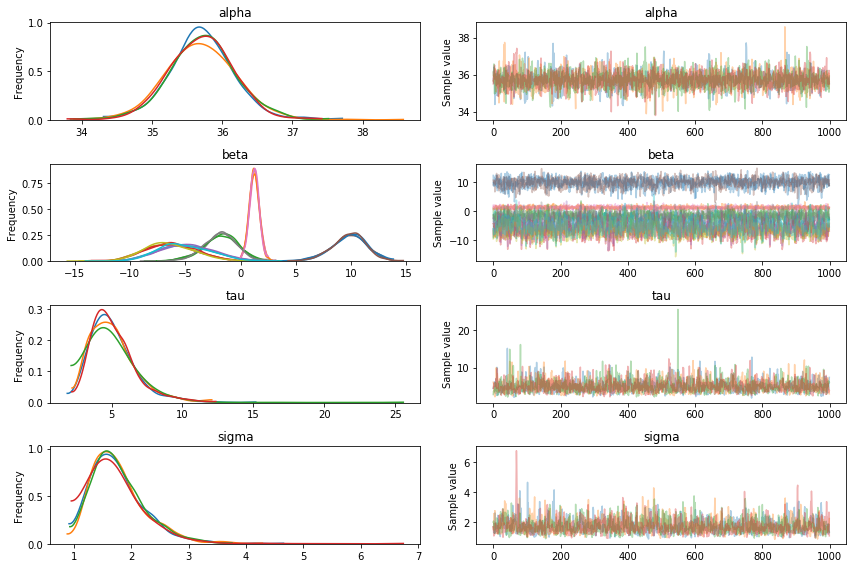

In [14]:
pm.traceplot(trace);

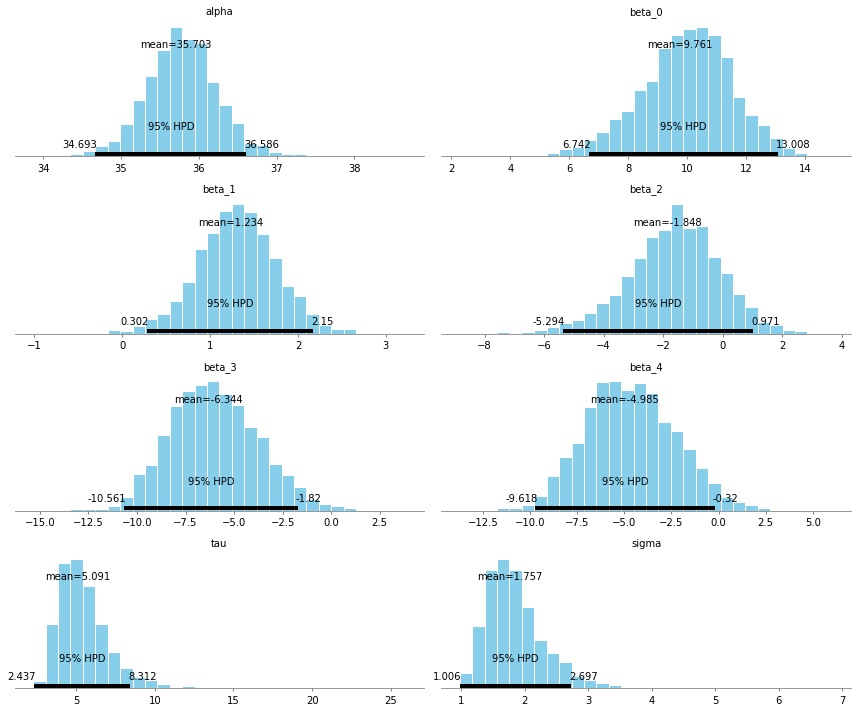

In [15]:
pm.plot_posterior(trace);

In [16]:
nppc = 100
ppc  = pm.sample_posterior_predictive(trace, samples=nppc, model=model)

100%|██████████| 100/100 [00:00<00:00, 392.18it/s]


In [17]:
print(np.mean(ppc['y'], axis=0)-yobs)

[-0.03707144 -1.18895452 -2.04305493 -0.88127059 -0.34592406  1.35065695
  3.52520877  0.7240622  -0.62774251  1.3885477  -0.97698094 -0.46074571
 -0.04962957  0.61802742 -2.59470842  1.5573012 ]


In [18]:
print(pm.loo(trace, model=model))

LOO_r(LOO=72.40990489222705, LOO_se=6.315661463668716, p_LOO=6.874749858190565, shape_warn=1)


/Users/bara947/.local/intelpython3/envs/u18fest_env/lib/python3.6/site-packages/pymc3/stats.py:299: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")
